1. MARIO SETUP

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [2]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

In [6]:
# Create a flag - restart or not
done = True
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
# Close the game
env.close()

E:\PYTHON\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Po ustawieniu trybu wątku nie można go zmienić
  warnings.warn(str(err))
E:\PYTHON\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


KeyboardInterrupt: 

2. PREPROCESS ENVIRONMENT

In [4]:
# Install pytorch
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113


In [5]:
# Install stable baselines for RL stuff
!pip install stable-baselines3[extra]

In [6]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [7]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [8]:
#Capture one frame
state = env.reset()

In [11]:
#3 channels colour pic 240x256 3 bytes of RGB 
state.shape

(1, 240, 256, 4)

In [50]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [14]:
state, reward, done, info = env.step([5])

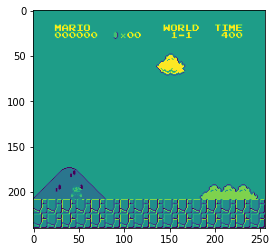

In [10]:
#Use Matplotlib to show the game frame
plt.imshow(state[0][:,:,3])

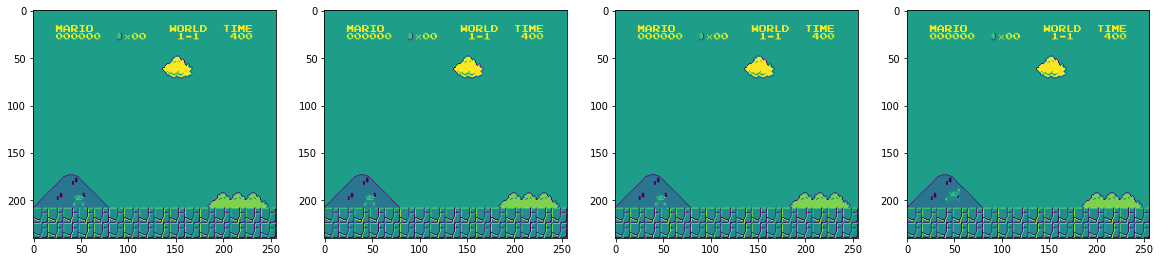

In [15]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

3. TRAIN THE RL MODEL

In [16]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [17]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [26]:
CHECKPOINT_DIR = 'E:/MarioAI/train'
LOG_DIR = 'E:/MarioAI/logs'

In [27]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [31]:
# This is the AI model started using Proximal Policy Optimization
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=10240) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [32]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Logging to E:/MarioAI/logs\PPO_4
------------------------------
| time/              |       |
|    fps             | 90    |
|    iterations      | 1     |
|    time_elapsed    | 113   |
|    total_timesteps | 10240 |
------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 2            |
|    time_elapsed         | 1205         |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0008510846 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | -0.00143     |
|    learning_rate        | 1e-06        |
|    loss                 | 21.5         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.000424    |
|    value_loss           | 36.3         |
-------------------

-----------------------------------------
| time/                   |             |
|    fps                  | 5           |
|    iterations           | 13          |
|    time_elapsed         | 22744       |
|    total_timesteps      | 133120      |
| train/                  |             |
|    approx_kl            | 0.002286431 |
|    clip_fraction        | 3.91e-05    |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.95        |
|    learning_rate        | 1e-06       |
|    loss                 | 38.6        |
|    n_updates            | 120         |
|    policy_gradient_loss | -0.000299   |
|    value_loss           | 25.4        |
-----------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 5            |
|    iterations           | 14           |
|    time_elapsed         | 23902        |
|    total_timesteps      | 1

KeyboardInterrupt: 

In [ ]:
model.save('thisisatestmodel')